# Capstone Module 2 — Bike Sharing Demand Prediction (Regression)

## Objective
Memprediksi jumlah peminjaman sepeda per jam (**cnt**) menggunakan fitur waktu dan cuaca, agar tim operasional bisa melakukan perencanaan distribusi sepeda lebih efektif.

## Target
- `cnt`: total rental per jam

## Catatan
- Kolom `casual` dan `registered` adalah **leakage** karena `cnt = casual + registered`, jadi tidak boleh dipakai sebagai fitur.


In [42]:
# ==============================
# IMPORTS (RUN ONCE)
# ==============================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
)

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
)

from xgboost import XGBRegressor

import pickle


## 1. Business Problem Understanding

Permintaan peminjaman sepeda per jam berubah-ubah. Jika supply kurang saat jam sibuk, terjadi stock-out (pelanggan gagal pinjam). Jika supply berlebihan saat sepi, biaya relokasi/maintenance jadi tidak efisien.

### Goal
Membangun model regresi untuk memprediksi `cnt` per jam agar tim operasional bisa:
- memperkirakan demand harian per jam
- mengantisipasi jam sibuk (peak hours)
- menyesuaikan strategi rebalancing

### Metrics
- **MAE** dan **RMSE** sebagai metrik utama (unit rental/jam).
- MAPE dicatat, tapi bisa bias saat demand kecil.


In [43]:
df = pd.read_csv("data_bike_sharing.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (12165, 11)


,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857


## 2. Data Understanding

Dataset berisi data peminjaman sepeda per jam dengan informasi waktu dan cuaca.

Checklist awal:
- tipe data & missing value
- duplikasi
- validasi leakage: `cnt = casual + registered`


In [45]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


In [46]:
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top):")
display(missing[missing > 0])

print("\nDuplicate rows:", df.duplicated().sum())



Missing values (top):


,0



Duplicate rows: 0


In [47]:
# Leakage check
if {"casual", "registered", "cnt"}.issubset(df.columns):
    ok = (df["casual"] + df["registered"] == df["cnt"]).mean()
    print(f"\nLeakage check (casual+registered==cnt): {ok:.4f}")


Leakage check (casual+registered==cnt): 1.0000


## 3. Preprocessing & Feature Engineering

Langkah:
1. Konversi `dteday` ke datetime
2. Buat timestamp (`dteday + hr`) untuk urutan waktu
3. Buat fitur waktu: `month`, `day_of_week`, `year`, `time_of_day`, `is_peak_hour`
4. Drop leakage columns (`casual`, `registered`) dan `dteday`


In [49]:
# ==============================
# FEATURE ENGINEERING + TIME-BASED SPLIT
# ==============================

df_model = df.copy()

df_model["dteday"] = pd.to_datetime(df_model["dteday"], errors="coerce")
df_model = df_model.dropna(subset=["dteday"]).copy()

df_model["timestamp"] = df_model["dteday"] + pd.to_timedelta(df_model["hr"], unit="h")

df_model["month"] = df_model["dteday"].dt.month
df_model["day_of_week"] = df_model["dteday"].dt.dayofweek
df_model["year"] = df_model["dteday"].dt.year

def categorize_time(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df_model["time_of_day"] = df_model["hr"].apply(categorize_time)
df_model["is_peak_hour"] = df_model["hr"].apply(lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0)

# Drop leakage + dteday
df_model = df_model.drop(columns=["casual", "registered", "dteday"], errors="ignore")

# Sort time
df_model = df_model.sort_values("timestamp").reset_index(drop=True)

# Split time-based 80/20
split_idx = int(len(df_model) * 0.8)
train_df = df_model.iloc[:split_idx].copy()
test_df  = df_model.iloc[split_idx:].copy()

X_train = train_df.drop(columns=["cnt", "timestamp"])
y_train = train_df["cnt"]

X_test  = test_df.drop(columns=["cnt", "timestamp"])
y_test  = test_df["cnt"]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train time:", train_df["timestamp"].min(), "->", train_df["timestamp"].max())
print("Test  time:", test_df["timestamp"].min(), "->", test_df["timestamp"].max())


Train: (9732, 12) Test: (2433, 12)
Train time: 2011-01-01 00:00:00 -> 2012-08-07 21:00:00
Test  time: 2012-08-07 23:00:00 -> 2012-12-31 21:00:00


## 4. Preprocessing Pipeline

- Kolom kategorikal di-encode dengan OneHotEncoder
- Kolom numerik diimpute (median) + scaling
- Output dibuat **dense** agar aman untuk HistGradientBoosting


In [50]:
# ==============================
# PREPROCESS PIPELINE (OHE + SCALE)
# ==============================

cat_cols = ["season", "weathersit", "holiday", "time_of_day"]
cat_cols = [c for c in cat_cols if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

def make_ohe_dense():
    # sklearn baru: sparse_output, sklearn lama: sparse
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", make_ohe_dense())
        ]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0
)

print("Categorical:", cat_cols)
print("Numeric     :", num_cols)


Categorical: ['season', 'weathersit', 'holiday', 'time_of_day']
Numeric     : ['hum', 'atemp', 'temp', 'hr', 'month', 'day_of_week', 'year', 'is_peak_hour']


## 5. Benchmark Models (TimeSeriesSplit)

Kita bandingkan beberapa model dengan cross-validation time series:
- Linear / Ridge
- Decision Tree
- Random Forest
- Gradient Boosting
- HistGradientBoosting
- XGBoost

Metrik utama: CV_RMSE dan CV_MAE.


In [51]:
# ==============================
# BENCHMARK MODELS
# ==============================

tscv = TimeSeriesSplit(n_splits=5)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
}

rows = []
for name, mdl in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", mdl)
    ])

    cv_rmse = -cross_val_score(pipe, X_train, y_train, cv=tscv,
                               scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    cv_mae  = -cross_val_score(pipe, X_train, y_train, cv=tscv,
                               scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    rows.append({"Model": name, "CV_RMSE": cv_rmse, "CV_MAE": cv_mae})

results_df = pd.DataFrame(rows).sort_values("CV_RMSE")
display(results_df)


,Model,CV_RMSE,CV_MAE
5,Hist Gradient Boosting,72.460247,47.857770
6,XGBoost,73.426122,49.221760
3,Random Forest,79.763081,51.850393
4,Gradient Boosting,86.785522,60.672807
2,Decision Tree,91.995423,59.868064
0,Linear Regression,115.674404,87.685162
1,Ridge Regression,115.678497,87.694673


## 6. Hyperparameter Tuning

Karena hasil benchmark teratas biasanya HGB/XGBoost, kita tuning dua model itu dengan RandomizedSearchCV.
Scoring: neg_root_mean_squared_error (fokus RMSE).


In [52]:
# ==============================
# TUNING HGB + XGBOOST
# ==============================

tuned_models = {}

# ---- HGB ----
hgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

hgb_param_dist = {
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1, 0.15],
    "model__max_depth": [None, 4, 6, 8],
    "model__max_iter": [200, 400, 600, 800],
    "model__min_samples_leaf": [10, 20, 40, 80],
    "model__l2_regularization": [0.0, 0.1, 0.5, 1.0],
}

hgb_search = RandomizedSearchCV(
    estimator=hgb_pipeline,
    param_distributions=hgb_param_dist,
    n_iter=30,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)
hgb_search.fit(X_train, y_train)
tuned_models["Hist Gradient Boosting"] = hgb_search.best_estimator_

# ---- XGBoost ----
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBRegressor(random_state=42, n_jobs=-1))
])

xgb_param_dist = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 4, 6, 8],
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1, 0.15],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "model__reg_lambda": [1.0, 2.0, 5.0],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_search.fit(X_train, y_train)
tuned_models["XGBoost"] = xgb_search.best_estimator_

print("Tuning done. Models:", list(tuned_models.keys()))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tuning done. Models: ['Hist Gradient Boosting', 'XGBoost']


## 7. Evaluation on Test Set & Final Model Selection

Kita evaluasi kedua model tuned pada test set:
- RMSE, MAE, MAPE, R²

Model terbaik dipilih berdasarkan RMSE (utama) dan MAE.


In [53]:
# ==============================
# EVALUATE TUNED MODELS ON TEST
# ==============================

rows = []
for name, mdl in tuned_models.items():
    y_pred = mdl.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    rows.append({"Model": name, "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2})

tuned_results_df = pd.DataFrame(rows).sort_values("RMSE")
display(tuned_results_df)

best_model_name = tuned_results_df.iloc[0]["Model"]
best_model = tuned_models[best_model_name]
print("BEST MODEL:", best_model_name)


,Model,RMSE,MAE,MAPE,R2
1,XGBoost,65.357151,43.002903,0.623739,0.912060
0,Hist Gradient Boosting,66.521922,43.510710,0.579192,0.908897


BEST MODEL: XGBoost


## 8. Error Analysis (Residual Plots)

- Residual distribution: melihat error dominan dan outlier.
- Residual vs Predicted: mengecek apakah error membesar saat demand tinggi.
- Actual vs Predicted: melihat kesesuaian prediksi terhadap nilai aktual.


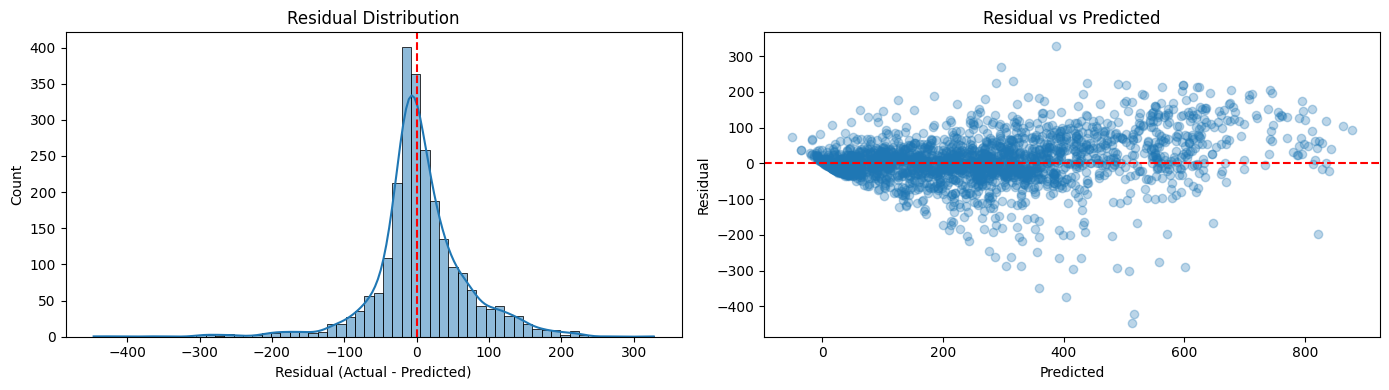

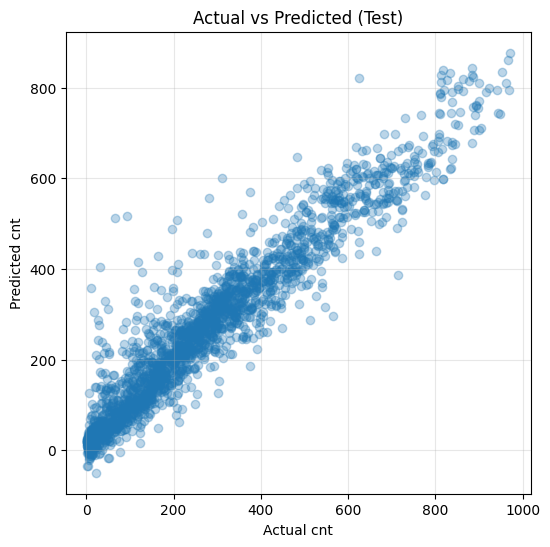

In [54]:
# ==============================
# FINAL PLOTS
# ==============================

y_pred = best_model.predict(X_test)
residuals = y_test.values - y_pred

# Residual distribution + residual vs predicted
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=60, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.grid(True, alpha=0.3)
plt.show()


## 9. Model Interpretability & Segment Performance

- Feature importance untuk mengetahui fitur mana paling berpengaruh.
- Segment analysis untuk melihat model paling buruk di kondisi apa (jam sibuk, musim, cuaca buruk).


In [63]:
# ==============================
# FEATURE IMPORTANCE + SEGMENT ANALYSIS
# ==============================

# Feature importance (jika model mendukung)
model_step = best_model.named_steps["model"]
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

if hasattr(model_step, "feature_importances_"):
    fi = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model_step.feature_importances_
    }).sort_values("Importance", ascending=False)

    display(fi.head(15))
else:
    print("Model tidak punya feature_importances_. Skip.")




,Feature,Importance
21,cat__time_of_day_night,0.359378
7,num__is_peak_hour,0.112582
3,num__hr,0.099820
6,num__year,0.087801
18,cat__time_of_day_afternoon,0.063687
2,num__temp,0.045911
5,num__day_of_week,0.043687
8,cat__season_1,0.033915
1,num__atemp,0.031986
14,cat__weathersit_3,0.021547


In [64]:
# Segment analysis
test_results = X_test.copy()
test_results["actual"] = y_test.values
test_results["predicted"] = y_pred
test_results["abs_error"] = np.abs(test_results["actual"] - test_results["predicted"])

print("\nTop 10 worst hours by MAE:")
display(test_results.groupby("hr")["abs_error"].mean().sort_values(ascending=False).head(10).to_frame("MAE_by_hour"))

print("\nError by peak vs non-peak:")
display(test_results.groupby("is_peak_hour")["abs_error"].agg(["mean", "median", "count"]).rename(index={0:"Non-peak", 1:"Peak"}))

print("\nMAE by season:")
season_map = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}
display(test_results.groupby("season")["abs_error"].mean().rename(index=season_map).to_frame("MAE"))

print("\nMAE by weathersit:")
display(test_results.groupby("weathersit")["abs_error"].mean().to_frame("MAE"))


Top 10 worst hours by MAE:


,MAE_by_hour
hr,
8,106.586686
17,88.627463
18,78.022558
16,63.383315
19,61.543454
15,57.673604
7,54.835412
12,52.018388
9,50.524888



Error by peak vs non-peak:


,mean,median,count
is_peak_hour,,,
Non-peak,33.101722,19.550987,1834
Peak,73.318033,53.484543,599



MAE by season:


,MAE
season,
Winter,72.022605
Summer,38.874943
Fall,41.508307



MAE by weathersit:


,MAE
weathersit,
1,41.217893
2,40.932208
3,68.146324


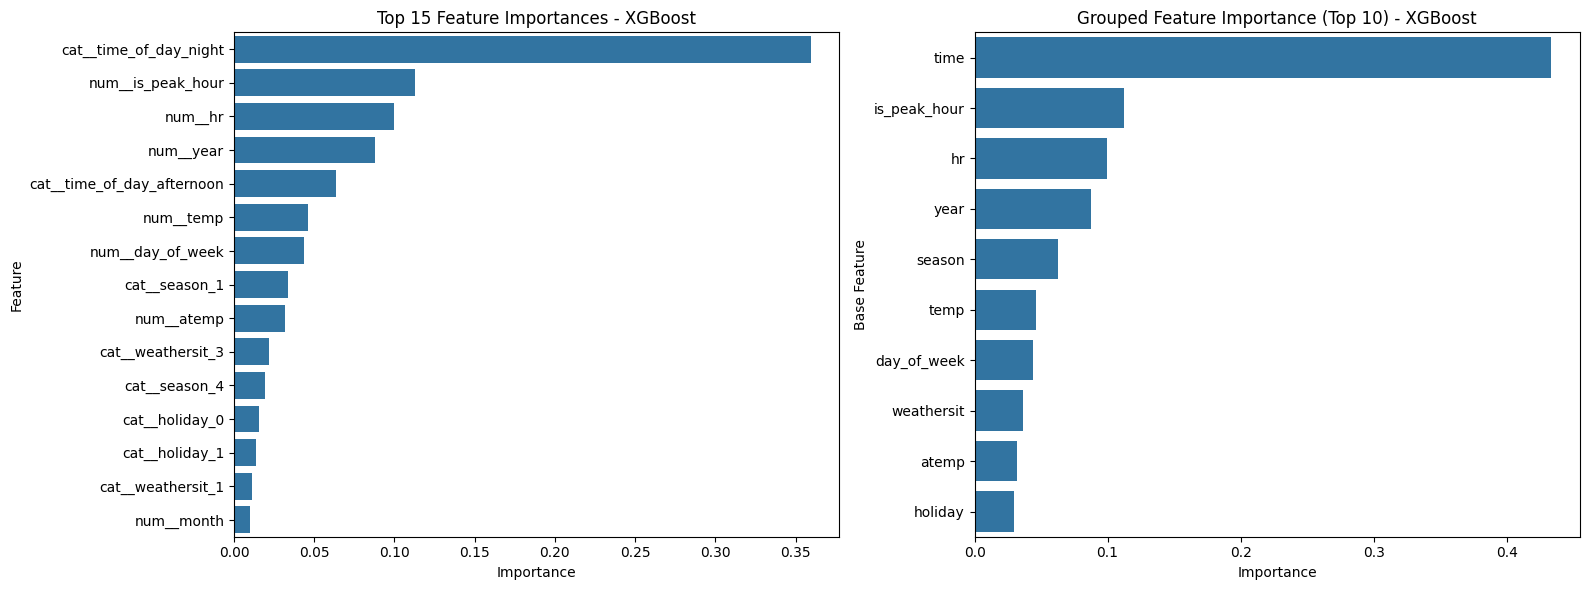

In [71]:
top_n = 15

plt.figure(figsize=(16, 6))

# kiri: top fitur (dummy)
plt.subplot(1, 2, 1)
sns.barplot(data=fi.head(top_n), x="Importance", y="Feature")
plt.title(f"Top {top_n} Feature Importances - {best_model_name}")
plt.xlabel("Importance")
plt.ylabel("Feature")

# kanan: grouped importance
plt.subplot(1, 2, 2)
sns.barplot(data=fi_grouped.head(10), x="Importance", y="BaseFeature")
plt.title(f"Grouped Feature Importance (Top 10) - {best_model_name}")
plt.xlabel("Importance")
plt.ylabel("Base Feature")

plt.tight_layout()
plt.show()


## Conclusion

Berdasarkan evaluasi pada test set, model terbaik adalah **XGBoost** dengan performa:
- **RMSE ≈ 65.36**
- **MAE ≈ 43.00**
- **R² ≈ 0.912**

Artinya, model sudah mampu menangkap pola utama permintaan peminjaman sepeda per jam dengan cukup baik (R² tinggi), dengan rata-rata kesalahan sekitar **43 peminjaman/jam** (MAE).

Namun, nilai **MAPE** terlihat tinggi. Hal ini umum terjadi pada data demand per jam karena ketika nilai aktual kecil (misalnya malam hari), persentase error bisa membesar walaupun selisih absolutnya tidak terlalu besar. Karena itu, untuk konteks operasional, **MAE dan RMSE lebih representatif** dibanding MAPE.

Dari analisis segment:
- Error jauh lebih besar pada **jam sibuk (peak hour)** dibanding non-peak.
- Error juga meningkat pada **musim Winter** dan kondisi cuaca tertentu (misalnya `weathersit = 3`), menunjukkan adanya faktor eksternal yang belum sepenuhnya tertangkap oleh fitur yang tersedia.

Dari feature importance, faktor yang paling memengaruhi prediksi adalah fitur waktu (jam/kelompok waktu) dan indikator jam sibuk, disusul variabel cuaca dan kalender (tahun, hari, musim).


## 10. Save Model (Pickle)

Pipeline disimpan sebagai satu objek (preprocess + model), jadi saat di-load bisa langsung `predict(X)`.


In [56]:
# ==============================
# SAVE MODEL (PICKLE)
# ==============================

model_filename = f"bike_sharing_{best_model_name.replace(' ', '_').lower()}.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

print("Saved as:", model_filename)

# Load test
with open(model_filename, "rb") as f:
    loaded_model = pickle.load(f)

sample_X = X_test.head(5)
sample_pred = loaded_model.predict(sample_X)

comparison = pd.DataFrame({
    "actual": y_test.head(5).values,
    "predicted": sample_pred,
    "error": y_test.head(5).values - sample_pred
})
display(comparison)


Saved as: bike_sharing_xgboost.pkl


,actual,predicted,error
0,138,147.188782,-9.188782
1,23,33.562954,-10.562954
2,6,18.732025,-12.732025
3,7,13.409225,-6.409225
4,7,13.864742,-6.864742


## Recommendation

### Rekomendasi penggunaan model (operasional)
1. Gunakan model untuk **forecast demand per jam** sebagai dasar penjadwalan dan distribusi sepeda, terutama untuk perencanaan harian.
2. Beri perhatian khusus pada **peak hour (pagi & sore)** karena error lebih tinggi. Untuk jam sibuk, gunakan output model sebagai “baseline”, lalu tambahkan buffer supply (cadangan) agar risiko stock-out lebih kecil.
3. Perhatikan kondisi **Winter** dan **cuaca buruk** (misalnya `weathersit = 3`) karena prediksi cenderung lebih sulit. Buat aturan operasional (contoh: extra buffer atau relokasi lebih awal) pada kondisi ini.

### Rekomendasi pengembangan model (improvement)
1. Tambahkan fitur historis yang aman dari leakage, seperti:
   - `lag_1`, `lag_24` (cnt jam sebelumnya dan cnt pada jam yang sama sehari sebelumnya)
   - rolling mean (misalnya 3 jam dan 24 jam) dengan `shift` agar hanya memakai data masa lalu  
   Biasanya ini peningkatan paling besar untuk forecasting demand per jam.
2. Pertimbangkan metrik tambahan yang lebih stabil untuk data demand kecil:
   - **sMAPE** atau **WAPE**, agar evaluasi “persentase error” lebih masuk akal daripada MAPE.
3. Uji model per segmen (A/B kecil):
   - bandingkan kebijakan rebalancing berbasis model vs tanpa model, khususnya pada peak hour, untuk melihat dampak ke jumlah rental yang berhasil dilayani.
